In [1]:
import sys
sys.path.append("../..")

#Defining libraries
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import datacube
from copy import deepcopy

import rasterio
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from modules import processing_module as processing
from modules.ai_module_extended import AIProcessor


2025-02-26 10:40:02.627400: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 10:40:02.628972: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 10:40:02.655100: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 10:40:02.655912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-26 10:40:03.142323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
'''
1-11-> Residential urban areas 
2-121,13->Industrial and abbandoned urban areas
3-122,123,124 Transportation infrastructure (streets, highways, airports, and ports)
4-14->Urban green areas
5-2->Agricultural areas
6-3->Forest
7-4/5->Hydro and humid bodies
'''
#Convert from copernicus code 2018 to an internal code
URBAN = 1
INDUSTRIAL = 2
TRANSPORTATION = 3
URBAN_VEGETATION = 4
RURAL = 5
FOREST = 6
WATER = 7
LC_NO_DATA = 9999
NO_DATA = -9999

    
# Function to check if the file is a tiff and must be read.
def check_wrong_files(f):
    if f == 'clip': return True #avoid entering the "clip" folder
    if 'ipynb' in f: return True #avoid entering the "ipynb_checkpoint" file
    if 'tar' in f: return True #avoid entering "tar" files
    if 'aux' in f: return True #avoid entering "aux" files
    return False

In [3]:
def fetch_from_odc(odc_datasets, samples, x=None, y=None):
    odc_df = None
    for df_name in odc_datasets:
        print(f"Sampling {df_name}")
        #odc datasets to be merged
        odc_product = df_name

        datasets = dc.find_datasets(product=odc_product)
        cf_data = dc.load(datasets=datasets)
        if x is not None and y is not None:
            cf_sel = cf_data.squeeze().sel(
                y=y, 
                x=x, 
                method='nearest'
            )
        else:
            cf_sel = cf_data.squeeze()

        cf_var_name = list(cf_data.data_vars.keys())[0]
        cf_df = cf_sel.to_dataframe()
        del cf_sel
        
        cf_df.rename(columns={cf_var_name:odc_product},inplace=True)
        cf_df.drop(['time','spatial_ref'],axis=1,inplace=True)
        if 'x' in list(cf_df.columns): cf_df.drop(['x'],axis=1,inplace=True)
        if 'y' in list(cf_df.columns): cf_df.drop(['y'],axis=1,inplace=True)

        del cf_data
        
        if odc_df is None:
            odc_df = cf_df.copy()
            print(len(samples), len(odc_df))
            odc_df = pd.concat([samples, odc_df], axis=1)
        else:
            odc_df = pd.concat([odc_df, cf_df[odc_product].astype('float32')], axis=1)

    odc_df = odc_df.dropna()

    print('odc_df Ready!')
    return odc_df


In [4]:
city = "MILANO"
city_epsg = 32632
data_folder = "data"
landcover_path = f"{data_folder}/landcover/DUSAF_2021_MCM_mapped.tif"
encode = True
normalize = True
train_model = True
model = 'ANN'

In [5]:
#Example of datacube config file:
#datacube_config_path = "/home/user/datacube.conf"

datacube_config_path = "/home/user/datacube.conf"
dc = datacube.Datacube(app = "my_app", config = datacube_config_path)
products = dc.list_products()
for p in products.name.values:
    print(p)

accelerazione_suolo
aspect
building_height
corine_urban_atlas_milan
densita_popolazione
dtm_milan
dusaf
dusaf15
dusaf99
fattori_amplificazione
flood_extent
flood_extent_year
geologia
hillshade
ixelles_dem
ixelles_distance_to_roads
ixelles_distance_to_tracks
ixelles_distance_to_water
ixelles_imperviousness
ixelles_landcover
ixelles_population
ixelles_slope
litologia_superficiale
main_road_distance
metropolitana
ndvi_2000
ndvi_2002
ndvi_2014
ndvi_2019
piezometrie_profondo
piezometrie_superficiale
piraeus_building_height
piraeus_dem
piraeus_distance_to_roads
piraeus_distance_to_tracks
piraeus_imperviousness
piraeus_landcover
piraeus_landcover_for_uhi
piraeus_population
piraeus_slope
plan_curvature
profile_curvature
reticolo_idrografico
river_distance
sabbie_falda
slope
sofia_building_height
sofia_dem
sofia_distance_to_road
sofia_distance_to_train_tracks
sofia_distance_to_water
sofia_imperviousness
sofia_landcover
sofia_population
sofia_slope
soggiacenza_falda
spi
strade_ferrovie
temperatu

/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points


In [6]:
#The datasets from the ODC from which data is sampled
odc_datasets = [
    'building_height', 'densita_popolazione',
    'main_road_distance', 'river_distance', 
    'water_distance'
]

In [7]:
importer = processing.HarmoniaProcessor()

# get raster parameters
with rasterio.open(landcover_path, driver="GTiff") as base_raster:
    transform = base_raster.transform
    init_x = transform[2]
    init_y = transform[5]
    step_x = transform[0]
    step_y = transform[4]

#import samples
base_path = f'training_samples'
sufix = '_feb16_50mil'
samples_path = f'{base_path}/{city}_samples{sufix}.csv'
samples = importer.import_df(samples_path, date_format=None)

samples['x'] = samples['x'].apply(
    lambda x: init_x + (x * step_x)
)
samples['y'] = samples['y'].apply(
    lambda y: init_y + (y * step_y)
)
samples = samples.loc[
    (samples['ndvi'] > -1) & 
    (samples['ndvi'] < 1) & 
    (samples['ndbi'] > -1) & 
    (samples['ndbi'] < 1) & 
    (samples['albedo'] > 0) & 
    (samples['albedo'] < 1)
]

samples


,x,y,landcover,uhi,uhii,ndvi,ndbi,albedo,lst,raster
0,492301.1148,5032540.992,1,0,-0.363373,0.736672,-0.248194,0.159342,306.01700,20180815
1,488281.1148,5031060.992,1,0,-0.599213,0.620605,-0.084578,0.154965,305.78116,20180815
2,505926.1148,5028125.992,1,0,-0.835052,0.745050,-0.250899,0.168430,305.54532,20180815
3,484221.1148,5048515.992,2,0,-0.021576,0.621915,-0.198456,0.122757,306.35880,20180815
4,530626.1148,5039830.992,2,0,-0.749603,0.873230,-0.432261,0.191063,305.63077,20180815
...,...,...,...,...,...,...,...,...,...,...
799995,505856.1148,5031065.992,5,1,3.745911,0.638478,-0.300185,0.127515,309.16160,20200719
799996,511181.1148,5025510.992,5,1,6.347015,0.367928,0.096560,0.173279,311.76270,20200719
799997,513056.1148,5043930.992,4,1,8.056030,0.630161,-0.089053,0.164044,313.47170,20200719
799998,512661.1148,5029825.992,5,1,3.417786,0.598087,-0.122851,0.187482,308.83347,20200719


In [8]:
samples.loc[samples['uhii'] > -20]

,x,y,landcover,uhi,uhii,ndvi,ndbi,albedo,lst,raster
0,492301.1148,5032540.992,1,0,-0.363373,0.736672,-0.248194,0.159342,306.01700,20180815
1,488281.1148,5031060.992,1,0,-0.599213,0.620605,-0.084578,0.154965,305.78116,20180815
2,505926.1148,5028125.992,1,0,-0.835052,0.745050,-0.250899,0.168430,305.54532,20180815
3,484221.1148,5048515.992,2,0,-0.021576,0.621915,-0.198456,0.122757,306.35880,20180815
4,530626.1148,5039830.992,2,0,-0.749603,0.873230,-0.432261,0.191063,305.63077,20180815
...,...,...,...,...,...,...,...,...,...,...
799995,505856.1148,5031065.992,5,1,3.745911,0.638478,-0.300185,0.127515,309.16160,20200719
799996,511181.1148,5025510.992,5,1,6.347015,0.367928,0.096560,0.173279,311.76270,20200719
799997,513056.1148,5043930.992,4,1,8.056030,0.630161,-0.089053,0.164044,313.47170,20200719
799998,512661.1148,5029825.992,5,1,3.417786,0.598087,-0.122851,0.187482,308.83347,20200719


In [9]:
# Compute mean and standard deviation of the 'uhii' column
mean_uhii = samples['uhii'].mean()
std_uhii = samples['uhii'].std()

# Define upper and lower bounds for outlier removal
lower_bound = mean_uhii - 3 * std_uhii
upper_bound = mean_uhii + 3.5 * std_uhii

# Filter the dataset to remove outliers
samples = samples[(samples['uhii'] >= lower_bound) & (samples['uhii'] <= upper_bound)]


In [10]:
samples.describe()

,x,y,landcover,uhi,uhii,ndvi,ndbi,albedo,lst,raster
count,796160.000000,7.961600e+05,796160.000000,796160.000000,796160.000000,796160.000000,796160.000000,7.961600e+05,796160.000000,7.961600e+05
mean,509417.744246,5.033829e+06,3.370953,0.502226,1.447053,0.573101,-0.194022,1.547026e-01,311.416459,2.018761e+07
std,16090.471594,9.602911e+03,1.780644,0.499995,5.421027,0.224335,0.185392,4.260641e-02,6.442024,2.544299e+04
min,477051.114800,5.001006e+06,1.000000,0.000000,-15.312347,-0.376618,-0.780856,5.699694e-07,292.697000,2.015071e+07
25%,496396.114800,5.026336e+06,2.000000,0.000000,-2.217071,0.392279,-0.353807,1.349790e-01,306.601470,2.016062e+07
50%,508426.114800,5.034651e+06,3.000000,1.000000,0.052292,0.599791,-0.185167,1.527671e-01,310.668900,2.019072e+07
75%,522311.114800,5.041616e+06,5.000000,1.000000,5.658050,0.777739,-0.041066,1.704924e-01,315.655820,2.021072e+07
max,543041.114800,5.054421e+06,6.000000,1.000000,20.837738,0.999843,0.689873,9.893655e-01,340.163020,2.022081e+07


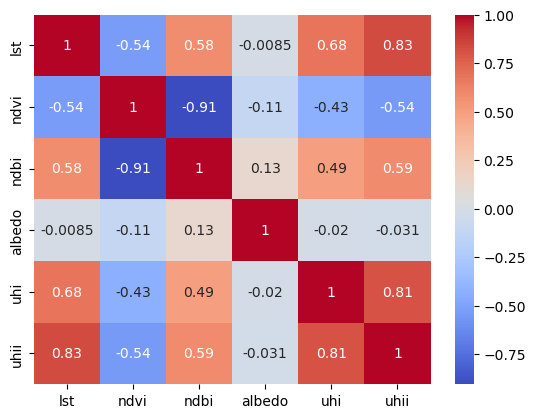

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = samples[["lst", "ndvi", "ndbi", "albedo", "uhi","uhii"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()


In [10]:
corr

,lst,ndvi,ndbi,albedo,uhi,uhii
lst,1.000000,-0.322266,0.573200,0.006930,0.680518,0.835605
ndvi,-0.322266,1.000000,-0.535306,0.029849,-0.259248,-0.319080
ndbi,0.573200,-0.535306,1.000000,-0.065398,0.490647,0.574618
albedo,0.006930,0.029849,-0.065398,1.000000,0.004731,0.004341
uhi,0.680518,-0.259248,0.490647,0.004731,1.000000,0.804506
uhii,0.835605,-0.319080,0.574618,0.004341,0.804506,1.000000


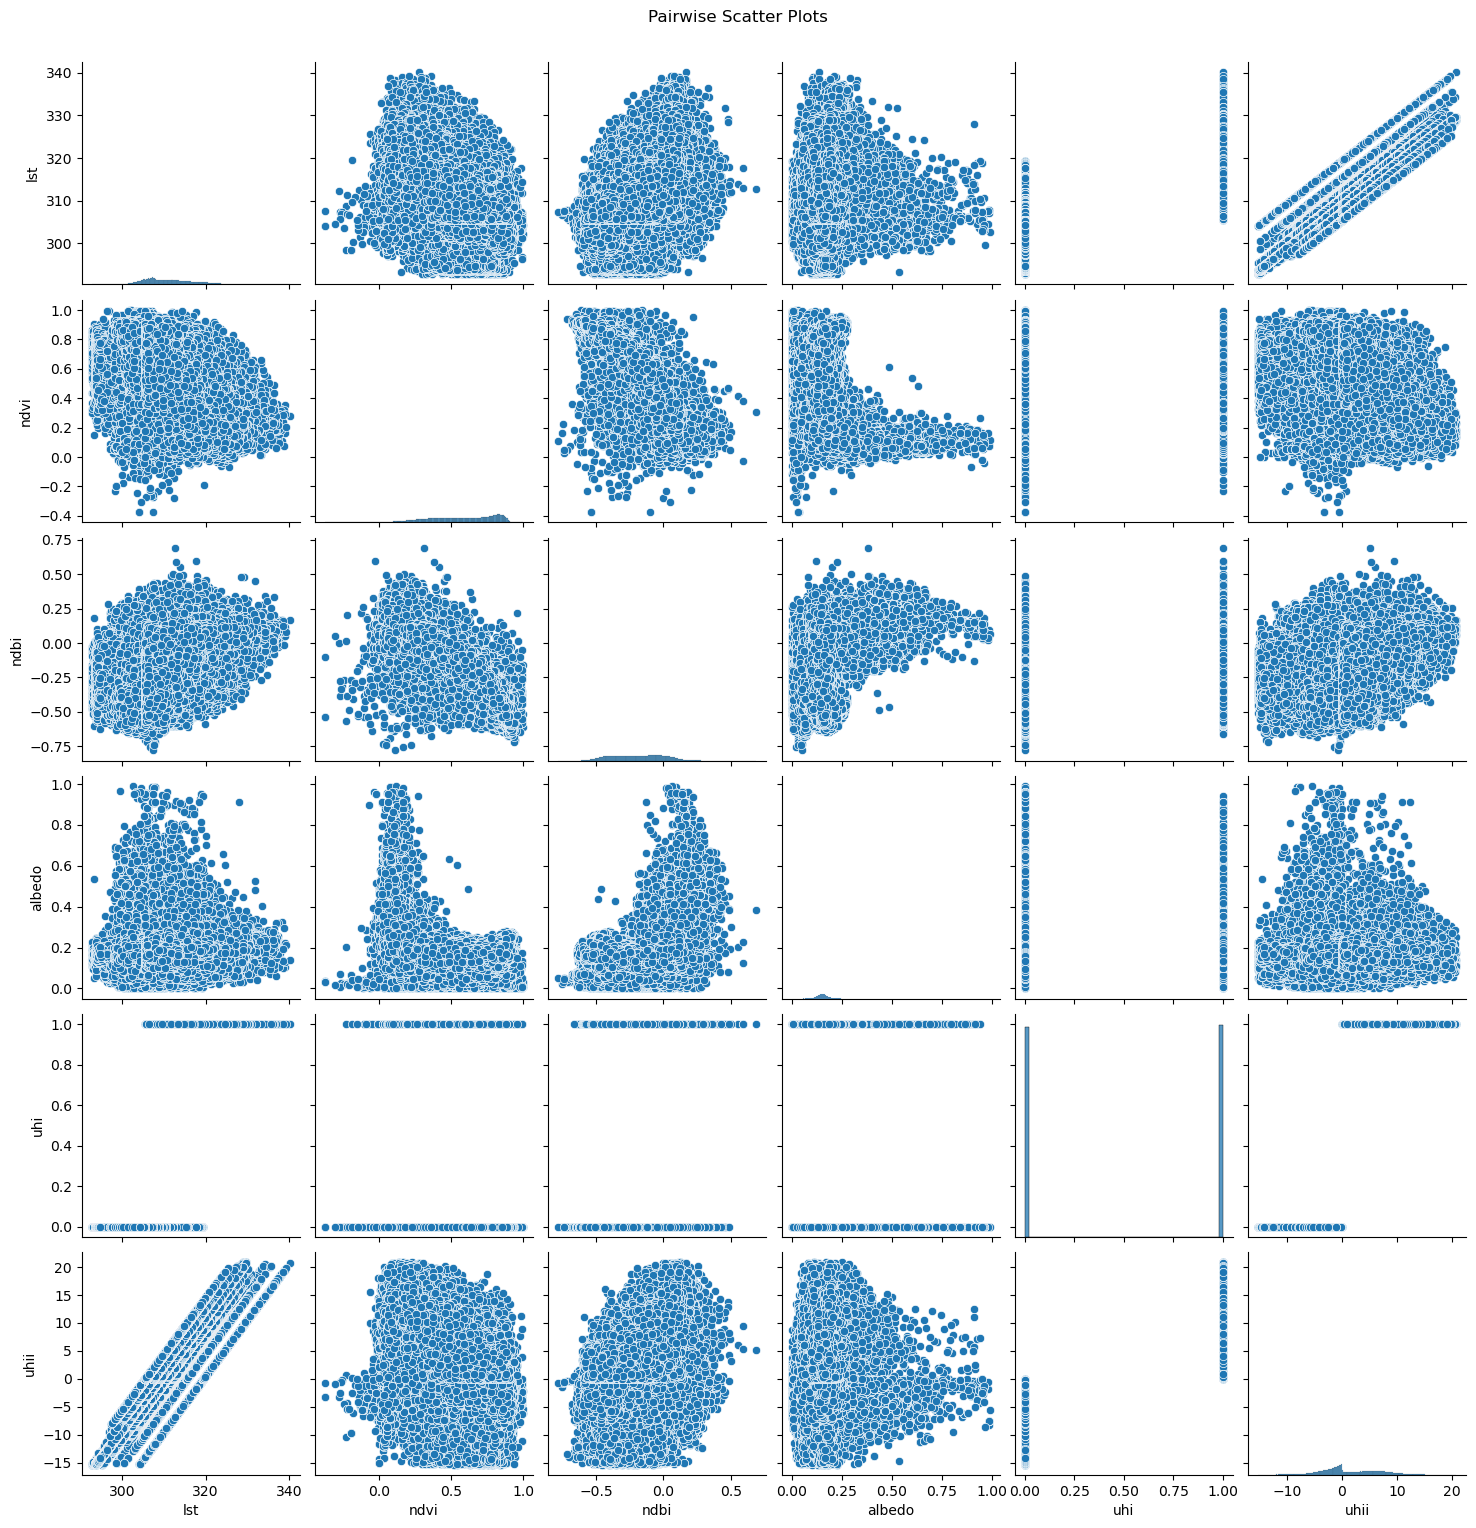

In [38]:
sns.pairplot(samples[['lst', 'ndvi', 'ndbi', 'albedo', 'uhi','uhii']])
plt.suptitle('Pairwise Scatter Plots', y=1.02)
plt.show()

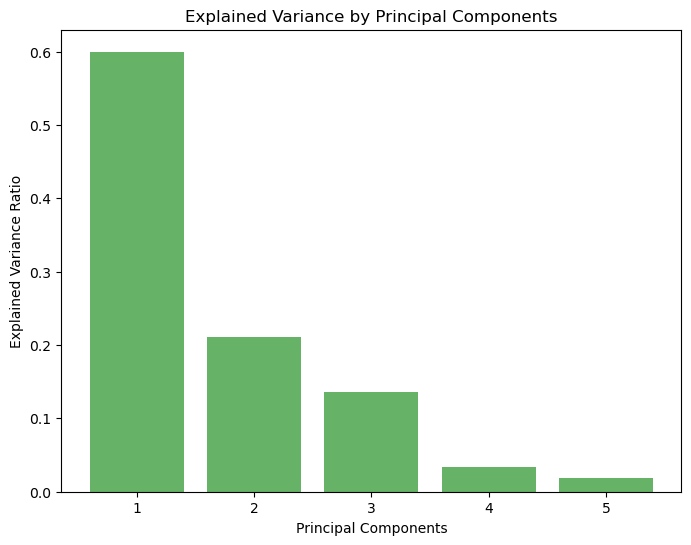

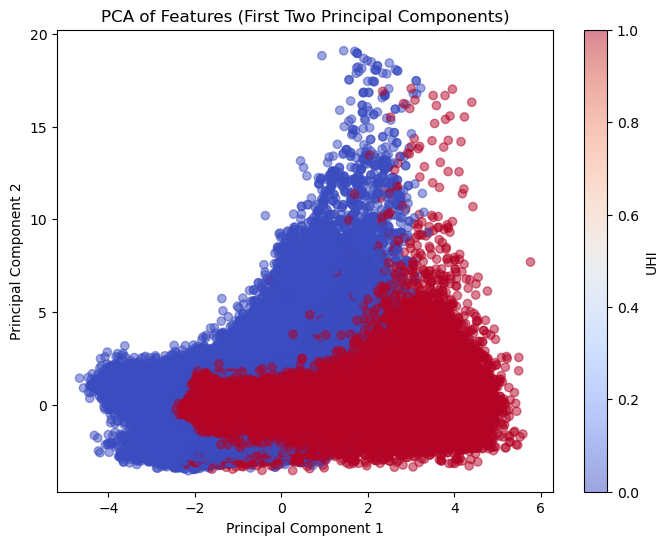

PCA Component Loadings (Contributions of Features to Components):
             PC1       PC2       PC3       PC4       PC5
lst     0.488792 -0.217439  0.467084  0.703991  0.005670
ndvi   -0.502074 -0.178543  0.494615 -0.029191 -0.685964
ndbi    0.516485  0.168313 -0.422226 -0.020636 -0.725405
albedo  0.051495  0.913805  0.402070 -0.020399  0.015245
uhii    0.489485 -0.239737  0.444132 -0.709015  0.054546


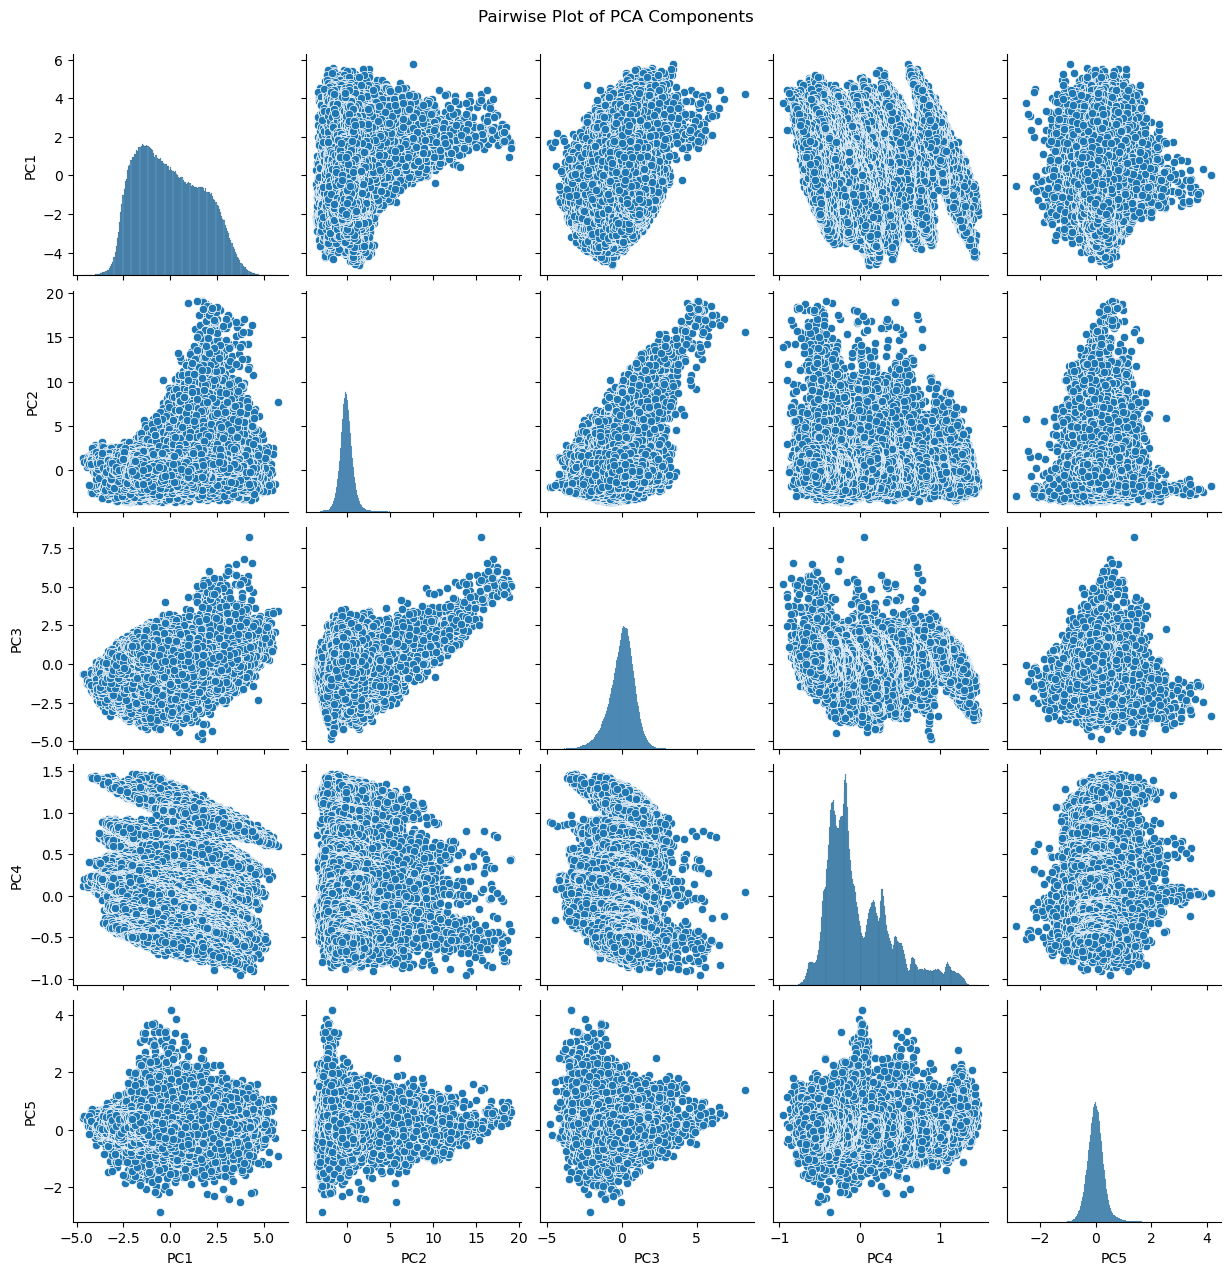

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'samples' is the DataFrame with your data

# 1. Select the features for PCA (excluding 'uhi' if it's a target)
features = ['lst', 'ndvi', 'ndbi', 'albedo','uhii']  # You can adjust this list

# 2. Standardize the features
X = samples[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 4. Explained variance ratio (to see how much each component explains the variance)
explained_variance = pca.explained_variance_ratio_

# Plot explained variance ratio for each component
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='g')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

# 5. Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=samples['uhi'], cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Features (First Two Principal Components)')
plt.colorbar(label='UHI')
plt.show()

# 6. Display the PCA component loadings (contributions of each feature)
loadings = pca.components_.T  # Transpose to match features to components
loading_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(len(features))], index=features)

# Print the loadings DataFrame (it shows how much each feature contributes to each PC)
print("PCA Component Loadings (Contributions of Features to Components):")
print(loading_df)

# 7. You can also plot all the components in a pairplot if you want to visualize correlations
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(len(features))])
sns.pairplot(pca_df)
plt.suptitle('Pairwise Plot of PCA Components', y=1.02)
plt.show()


In [11]:
single_positions = samples.drop_duplicates(subset=['x', 'y']).reset_index(drop=True)[['x','y']]
single_x_positions = single_positions.x.values
single_y_positions = single_positions.y.values

odc_df = fetch_from_odc(
    odc_datasets, 
    samples,
    x=xr.DataArray(single_x_positions, dims=['index']),
    y=xr.DataArray(single_y_positions, dims=['index'])
)

# set UHI column as integer
odc_df['uhi'] = odc_df['uhi'].apply(
    lambda x: int(x),
).astype('int8')

#coordinates as float32 to reduce size in disk
odc_df['x'] = odc_df['x'].astype('float64')
odc_df['y'] = odc_df['y'].astype('float64')
odc_df['lst'] = odc_df['lst'].astype('float32')
odc_df['ndvi'] = odc_df['ndvi'].astype('float32')
odc_df['albedo'] = odc_df['albedo'].astype('float32')
odc_df['landcover'] = odc_df['landcover'].astype('int32')
odc_df['uhii'] = odc_df['uhii'].astype('float32')
odc_df['uhi'] = odc_df['uhi'].astype('uint8')

print("ready")
odc_df
    

Sampling building_height
796160 787508
Sampling densita_popolazione
Sampling main_road_distance
Sampling river_distance
Sampling water_distance
odc_df Ready!
ready


,x,y,landcover,uhi,uhii,ndvi,ndbi,albedo,lst,raster,building_height,densita_popolazione,main_road_distance,river_distance,water_distance
0,492301.1148,5032540.992,1,0,-0.363373,0.736672,-0.248194,0.159342,306.016998,20180815.0,0.0,0.000,173.349365,5.000000,5.000000
1,488281.1148,5031060.992,1,0,-0.599213,0.620605,-0.084578,0.154965,305.781158,20180815.0,0.0,0.000,2234.552490,5.000000,5.000000
2,505926.1148,5028125.992,1,0,-0.835052,0.745050,-0.250899,0.168430,305.545319,20180815.0,0.0,0.000,61.846584,83.815269,83.815269
3,484221.1148,5048515.992,2,0,-0.021576,0.621916,-0.198456,0.122757,306.358795,20180815.0,0.0,0.000,898.846497,1281.425049,136.473434
4,530626.1148,5039830.992,2,0,-0.749603,0.873230,-0.432261,0.191063,305.630768,20180815.0,0.0,0.000,428.544037,15.000000,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787503,525906.1148,5037520.992,5,1,8.507202,0.599597,-0.150240,0.151556,313.922882,20200719.0,0.0,0.000,14.142136,0.000000,0.000000
787504,518816.1148,5020900.992,5,1,5.041321,0.771635,-0.377297,0.189813,310.457001,20200719.0,0.0,0.000,139.283890,63.245552,63.245552
787505,510231.1148,5037745.992,4,1,4.501282,0.754846,-0.360910,0.164882,309.916962,20200719.0,0.0,0.007,264.433350,115.974129,115.974129
787506,530251.1148,5042200.992,5,1,0.122803,0.785397,-0.295853,0.176022,305.538483,20200719.0,0.0,0.000,208.925812,25.000000,25.000000


In [12]:
#Encode Columns
train_df = odc_df.copy()
if encode:
    #encode categorical columns
    encoding_columns = ['landcover']
    encoders = {
        "landcover": OneHotEncoder(sparse=False, dtype='uint16', handle_unknown='ignore')
    }

    for enc in encoding_columns:
        enc_list = train_df[enc].values.reshape(-1, 1)
        encoded_data = encoders[enc].fit_transform(enc_list)

        encoded_columns = [f"{enc}_{category}" for category in encoders[enc].get_feature_names_out([enc])]
        train_df = pd.concat(
            [train_df, pd.DataFrame(encoded_data, columns=encoded_columns, dtype='int32')], 
            axis=1,
            join='inner'
        )
        train_df = train_df.drop(columns=[enc])

    train_df = train_df.dropna()

    #drop resulting _nan columns
    _nan_columns = list(filter(lambda x: '_nan' in x, list(train_df.columns)))
    train_df = train_df.drop(columns=_nan_columns)

    
#drop raster, x, and y columns
train_df_complete = train_df.drop(columns=['raster','x','y'])

for col in odc_datasets:
    train_df_complete = train_df_complete.loc[
        train_df_complete[col] != -9999
    ]

train_df_complete


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,uhi,uhii,ndvi,ndbi,albedo,lst,building_height,densita_popolazione,main_road_distance,river_distance,water_distance,landcover_landcover_1,landcover_landcover_2,landcover_landcover_3,landcover_landcover_4,landcover_landcover_5,landcover_landcover_6
0,0,-0.363373,0.736672,-0.248194,0.159342,306.016998,0.0,0.0,173.349365,5.000000,5.000000,1,0,0,0,0,0
1,0,-0.599213,0.620605,-0.084578,0.154965,305.781158,0.0,0.0,2234.552490,5.000000,5.000000,1,0,0,0,0,0
2,0,-0.835052,0.745050,-0.250899,0.168430,305.545319,0.0,0.0,61.846584,83.815269,83.815269,1,0,0,0,0,0
3,0,-0.021576,0.621916,-0.198456,0.122757,306.358795,0.0,0.0,898.846497,1281.425049,136.473434,0,1,0,0,0,0
4,0,-0.749603,0.873230,-0.432261,0.191063,305.630768,0.0,0.0,428.544037,15.000000,15.000000,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778306,0,-6.374847,0.886846,-0.506836,0.135185,299.040833,0.0,0.0,378.219543,2626.713867,1214.948608,0,0,0,0,1,0
778307,0,-3.814758,0.871511,-0.442200,0.219025,301.600922,0.0,0.0,557.000854,310.000000,310.000000,0,0,0,0,1,0
778308,0,-3.052551,0.874335,-0.524177,0.155234,302.363129,0.0,0.0,130.862518,36.055511,36.055511,0,0,0,1,0,0
778309,0,-2.632111,0.889827,-0.542005,0.167991,302.783569,0.0,0.0,130.096115,119.268608,119.268608,0,0,0,0,1,0


In [13]:
train_df_complete = train_df_complete[['uhii', 'ndvi', 'ndbi', 'albedo','building_height',
       'densita_popolazione', 'main_road_distance', 'river_distance',
       'water_distance', 'landcover_landcover_1', 'landcover_landcover_2',
       'landcover_landcover_3', 'landcover_landcover_4',
       'landcover_landcover_5', 'landcover_landcover_6']]

In [14]:
train_df_complete

,uhii,ndvi,ndbi,albedo,building_height,densita_popolazione,main_road_distance,river_distance,water_distance,landcover_landcover_1,landcover_landcover_2,landcover_landcover_3,landcover_landcover_4,landcover_landcover_5,landcover_landcover_6
0,-0.363373,0.736672,-0.248194,0.159342,0.0,0.0,173.349365,5.000000,5.000000,1,0,0,0,0,0
1,-0.599213,0.620605,-0.084578,0.154965,0.0,0.0,2234.552490,5.000000,5.000000,1,0,0,0,0,0
2,-0.835052,0.745050,-0.250899,0.168430,0.0,0.0,61.846584,83.815269,83.815269,1,0,0,0,0,0
3,-0.021576,0.621916,-0.198456,0.122757,0.0,0.0,898.846497,1281.425049,136.473434,0,1,0,0,0,0
4,-0.749603,0.873230,-0.432261,0.191063,0.0,0.0,428.544037,15.000000,15.000000,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778306,-6.374847,0.886846,-0.506836,0.135185,0.0,0.0,378.219543,2626.713867,1214.948608,0,0,0,0,1,0
778307,-3.814758,0.871511,-0.442200,0.219025,0.0,0.0,557.000854,310.000000,310.000000,0,0,0,0,1,0
778308,-3.052551,0.874335,-0.524177,0.155234,0.0,0.0,130.862518,36.055511,36.055511,0,0,0,1,0,0
778309,-2.632111,0.889827,-0.542005,0.167991,0.0,0.0,130.096115,119.268608,119.268608,0,0,0,0,1,0


In [15]:
train_df = train_df_complete.copy()

In [16]:
model = AIProcessor('ANN','regression',False)
X = train_df.drop('uhii', axis=1)
y = train_df['uhii']
model.set_data(partition=True, normalize=True, data={'X': X, 'y': y})
model.fit()
model.assess()

4808/4808 [==============================] - 1s 241us/step
Regression Metrics:
Mean Absolute Error (MAE): 3.1187348
Mean Squared Error (MSE): 16.938993
Root Mean Squared Error (RMSE): 4.1157007
R² Score: 0.43255358784479003


In [21]:
import shap
X_train = model.X_train
X_test = model.X_test
X_background = X_train[:50]  # 50 samples for efficiency
band_names = train_df.columns
# Initialize SHAP DeepExplainer
explainer = shap.DeepExplainer(model.model, X_background)

# Compute SHAP values for test samples
shap_values_ = explainer.shap_values(X_test[:50])  # Explain 10 test samples

# Convert SHAP values to numpy array for easy processing
shap_values = np.array(shap_values_)  # Shape: (1, 10, 33, 33, 7)



Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [24]:
shap.plots.beeswarm(shap.plots.waterfall(shap_values_[0]))

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In [ ]:
# -------------------------------
# 🟢 GLOBAL EXPLANATION (Summary Plot)
# -------------------------------
# Compute the mean absolute SHAP value across spatial dimensions
#shap_mean = np.abs(shap_values[0]).mean(axis=(0, 1, 2))  # Shape: (7,)

# Create a summary plot (bar chart for feature importance)
plt.figure(figsize=(10, 5))
plt.bar(band_names, shap_values, color="royalblue")  # Now correctly shaped
plt.xticks(range(7), band_names)
plt.xlabel("Band")
plt.ylabel("Mean SHAP Value")
plt.title("Feature Importance (SHAP) per Spectral Band")
plt.show()

 230/4799 [>.............................] - ETA: 0s 

4799/4799 [==============================] - 1s 219us/step


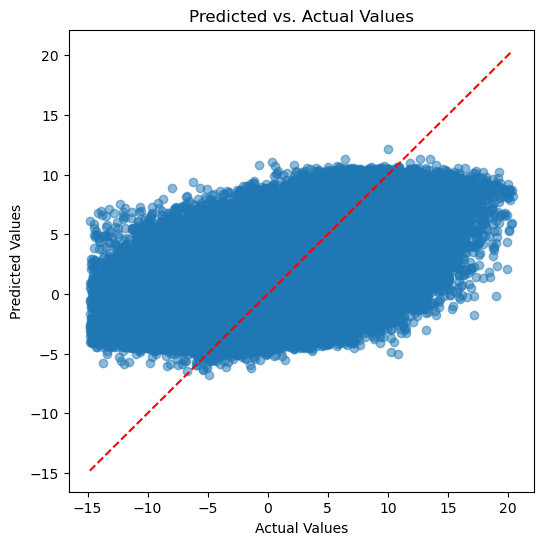

In [68]:
plt.figure(figsize=(6,6))
plt.scatter(model.y_test, model.model.predict(model.X_test), alpha=0.5)
plt.plot([min(model.y_test), max(model.y_test)], [min(model.y_test), max(model.y_test)], 'r', linestyle="dashed")  # Ideal 1:1 line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.show()

In [45]:
model.predict(model.X_test)

 234/4799 [>.............................] - ETA: 0s 

 655/4799 [===>..........................] - ETA: 0s

/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


4799/4799 [==============================] - 1s 219us/step


array([[-284.78772],
       [-281.25903],
       [-282.55057],
       ...,
       [-318.89294],
       [-301.1209 ],
       [-288.66534]], dtype=float32)

In [50]:
model.y_test

538910    3.404205
187741    0.453308
547182    6.972626
427258   -0.534088
588874    0.969299
            ...   
27318    -0.910248
483847   -5.638550
443861    4.651031
750507   -0.687256
560979   -2.858887
Name: uhii, Length: 153563, dtype: float32

In [45]:
model = AIProcessor('ANN','regression',False)

In [46]:
X = train_df.drop('uhii', axis=1)
y = train_df['uhii']
model.fit(X,y)

19229/19229 [==============================] - 6s 318us/step - loss: 14.8176 - mse: 14.8176


In [27]:
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler, f)

In [29]:
# predict probabilities for test set
yhat_probs = ai_model.predict(X_test)
# predict crisp classes for test set
#yhat_classes = ai_model.predict_classes(X_test)

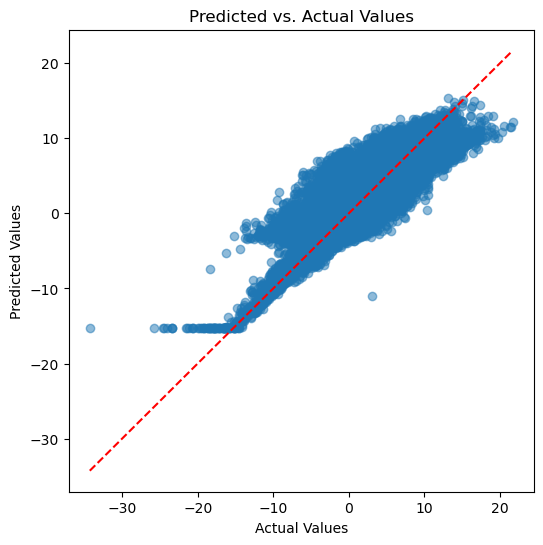

In [34]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, yhat_probs, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', linestyle="dashed")  # Ideal 1:1 line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.show()


In [66]:
labels = ['NDVI', 'LST', 'Building height', 'Population density',
       'Main road distance', 'River distance', 'Water distance',
       'Residential urban', 'Industrial urban',
       'Transportation infrastructure', 'Urban green areas',
       'Agricultural areas', 'Forest']

In [67]:
labels = ['NDVI', 'NDBI', 'albedo', 'LST', 'Building height', 'Population density',
       'Main road distance', 'River distance', 'Water distance',
       'Residential urban', 'Industrial urban',
       'Transportation infrastructure', 'Urban green areas',
       'Agricultural areas', 'Forest']

In [68]:
X_train_df.columns.values

array(['ndvi', 'ndbi', 'albedo', 'lst', 'building_height',
       'densita_popolazione', 'main_road_distance', 'river_distance',
       'water_distance', 'landcover_landcover_1', 'landcover_landcover_2',
       'landcover_landcover_3', 'landcover_landcover_4',
       'landcover_landcover_5', 'landcover_landcover_6'], dtype=object)

In [69]:
if train_model:
    if model == 'RF':
        columns_list = list(X_train_df.columns)
        importances = pd.DataFrame(ai_model.feature_importances_)
        importances['label'] = pd.Series(labels)
        importances = importances.sort_values(by=0, ascending=False).reset_index(drop=True)
        importer.show_plot(importances, 'label', 0)
    elif model == 'ANN':
        '''
        columns_list = list(X_train_df.columns)
        importances = pd.DataFrame(ai_model.coef_)
        importances['label'] = pd.Series(X_train_df.columns.values)
        importances = importances.sort_values(by=0, ascending=False).reset_index(drop=True)
        importer.show_plot(importances, 'label', 0)
        '''

In [70]:
importances

,0,label
0,0.779896,LST
1,0.081163,NDVI
2,0.067675,NDBI
3,0.016698,Agricultural areas
4,0.012244,albedo
5,0.010319,Population density
6,0.006511,Residential urban
7,0.006457,Industrial urban
8,0.004871,Urban green areas
9,0.003112,Water distance


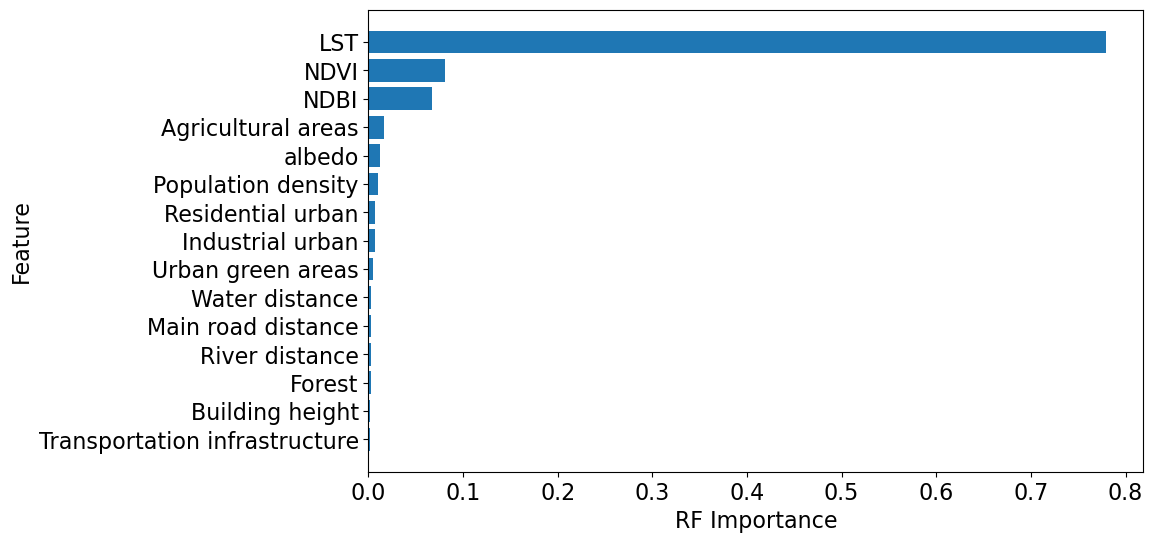

In [71]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(importances['label'])),list(reversed(importances[0])))
'''
plt.xticks(rotation=45, ha="right")
plt.xlabel("Land Cover Class")
plt.ylabel("Total Area (km²)")
plt.title("Land Cover Change Across Different Datasets")
plt.legend(title="Dataset", bbox_to_anchor=(1, 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
'''
plt.xlabel('RF Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.show()


In [40]:
str(score)[2:4] 

'76'

In [18]:
model_file = 'model/model_ANN_76_UHII_50mil.pkl'
sufix = '_UHII_50mil'

In [21]:
if train_model:
    #save model
    model_score = str(score)[2:4]
    model_file = f'model/model_{model}_{model_score}{sufix}.pkl'
    print(model_file)
    with open(model_file, 'wb') as file:
        pickle.dump(ai_model, file)

model/model_ANN_76_UHII_50mil.pkl


# PREDICTION

In [22]:
if not train_model:
    #model_score = '85'
    # Load the trained model using pickle
    #model_file = f'model/model_{model}_86.pkl'
    with open(model_file, 'rb') as file:
        ai_model = pickle.load(file)

In [25]:
# predict the whole image
importer = processing.HarmoniaProcessor()

# get raster parameters from landcover
with rasterio.open(landcover_path, driver="GTiff") as base_raster:
    transform = base_raster.transform
    init_x = transform[2]
    init_y = transform[5]
    step_x = transform[0]
    step_y = transform[4]

#import samples
base_path = f'training_samples'
#sufix = '_DUSAF'
predict_path = f'{base_path}/{city}_predict{sufix}.csv'
predict = importer.import_df(predict_path, date_format=None)

predict['lst'] = predict['lst'].astype('float32')
predict['ndvi'] = predict['ndvi'].astype('float32')
predict['ndbi'] = predict['ndbi'].astype('float32')
predict['albedo'] = predict['albedo'].astype('float32')
predict['landcover'] = predict['landcover'].astype('int32')
predict['x'] = predict['x'].astype('float64')
predict['y'] = predict['y'].astype('float64')

predict['landcover'] = predict['landcover']#.apply(map_urban_atlas_class).astype('int32')

predict['x'] = predict['x'].apply(
    lambda x: init_x + (x * step_x)
)
predict['y'] = predict['y'].apply(
    lambda y: init_y + (y * step_y)
)

predict_x_positions = predict.x.values
predict_y_positions = predict.y.values

full_data_df = fetch_from_odc(
    odc_datasets, 
    predict,
    x=xr.DataArray(predict_x_positions, dims=['index']),
    y=xr.DataArray(predict_y_positions, dims=['index'])
)

#remove water pixels
full_data_df = full_data_df.loc[
    full_data_df['landcover'] != WATER
].reset_index(drop=True)
print("ready")

#remove nodata from odc datasets
for col in odc_datasets:
    full_data_df = full_data_df.loc[
        full_data_df[col] != 9999
    ].reset_index(drop=True)

full_data_df

Sampling building_height
63008537 63008537
Sampling densita_popolazione
Sampling main_road_distance
Sampling river_distance
Sampling water_distance
odc_df Ready!
ready


,x,y,landcover,lst,ndvi,ndbi,albedo,building_height,densita_popolazione,main_road_distance,river_distance,water_distance
0,495341.1148,5054280.992,6,309.989227,0.444257,-0.133687,0.138582,0.0,0.0,3550.003662,916.856079,916.856079
1,495346.1148,5054280.992,6,310.381805,0.672136,-0.257020,0.123007,0.0,0.0,3551.936035,920.570435,920.570435
2,495351.1148,5054280.992,6,310.381805,0.672136,-0.257020,0.123007,0.0,0.0,3553.874512,924.296997,924.296997
3,495321.1148,5054275.992,6,309.989227,0.444257,-0.133687,0.138582,0.0,0.0,3537.711182,898.721313,898.721313
4,495326.1148,5054275.992,6,309.989227,0.444257,-0.133687,0.138582,0.0,0.0,3539.622070,902.399597,902.399597
...,...,...,...,...,...,...,...,...,...,...,...,...
61865261,537921.1148,5001000.992,5,311.829102,0.529260,-0.115972,0.162138,0.0,0.0,0.000000,2256.014160,2256.014160
61865262,537926.1148,5001000.992,5,311.829102,0.529260,-0.115972,0.162138,0.0,0.0,0.000000,2252.026855,2252.026855
61865263,537931.1148,5001000.992,5,311.829102,0.529260,-0.115972,0.162138,0.0,0.0,0.000000,2248.043457,2248.043457
61865264,537936.1148,5001000.992,5,311.308105,0.568186,-0.153507,0.158356,0.0,0.0,0.000000,2244.064453,2244.064453


In [26]:
full_data_df.describe()

,x,y,landcover,lst,ndvi,ndbi,albedo,building_height,densita_popolazione,main_road_distance,river_distance,water_distance
count,6.186527e+07,6.186527e+07,6.186527e+07,6.186527e+07,6.186527e+07,6.186527e+07,6.186527e+07,6.186527e+07,6.186527e+07,6.186527e+07,6.186527e+07,6.186527e+07
mean,5.095755e+05,5.034260e+06,3.775909e+00,3.139847e+02,5.520092e-01,-1.750011e-01,1.558949e-01,8.200905e-01,1.942939e-03,7.164906e+02,2.273791e+02,2.054707e+02
std,1.585744e+04,9.474302e+03,1.739272e+00,5.033173e+00,2.244368e-01,1.679931e-01,2.885390e-02,3.348607e+00,5.186833e-03,7.531017e+02,3.879923e+02,3.223694e+02
min,4.770711e+05,5.001001e+06,1.000000e+00,3.000052e+02,-8.935774e+01,-1.769709e+01,3.376951e-03,-1.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.966811e+05,5.027111e+06,2.000000e+00,3.098672e+02,3.959259e-01,-3.206557e-01,1.400028e-01,0.000000e+00,0.000000e+00,2.089258e+02,3.807887e+01,3.807887e+01
50%,5.084811e+05,5.035351e+06,5.000000e+00,3.149434e+02,5.713587e-01,-1.567824e-01,1.557115e-01,0.000000e+00,0.000000e+00,4.909175e+02,9.604687e+01,9.433981e+01
75%,5.220461e+05,5.041846e+06,5.000000e+00,3.180372e+02,7.335933e-01,-3.657416e-02,1.708810e-01,0.000000e+00,1.000000e-03,9.346791e+02,2.263846e+02,2.192031e+02
max,5.430561e+05,5.054281e+06,8.000000e+00,3.348748e+02,5.278276e+01,1.229743e+00,1.204706e+00,2.007380e+02,1.580000e-01,5.238096e+03,3.820906e+03,3.648150e+03


In [27]:
if encode:
    #encode categorical columns
    encoding_columns = ['landcover']
    all_encoded_columns = []
    for enc in encoding_columns:
        enc_list = full_data_df[enc].values.reshape(-1, 1)
        encoded_data = encoders[enc].transform(enc_list)

        encoded_columns = [f"{enc}_{category}" for category in encoders[enc].get_feature_names_out([enc])]
        print(encoded_columns)
        full_data_df = pd.concat([full_data_df, pd.DataFrame(encoded_data, columns=encoded_columns)], axis=1)
        all_encoded_columns += encoded_columns.copy()
        full_data_df = full_data_df.drop(columns=[enc])

    full_data_df = full_data_df.dropna()
    for enc_col in all_encoded_columns:
        full_data_df[enc_col] = full_data_df[enc_col].astype('uint16')

    #drop resulting _nan columns
    _nan_columns = list(filter(lambda x: '_nan' in x, list(full_data_df.columns)))
    full_data_df = full_data_df.drop(columns=_nan_columns)

full_data_df

['landcover_landcover_1', 'landcover_landcover_2', 'landcover_landcover_3', 'landcover_landcover_4', 'landcover_landcover_5', 'landcover_landcover_6']


,x,y,lst,ndvi,ndbi,albedo,building_height,densita_popolazione,main_road_distance,river_distance,water_distance,landcover_landcover_1,landcover_landcover_2,landcover_landcover_3,landcover_landcover_4,landcover_landcover_5,landcover_landcover_6
0,495341.1148,5054280.992,309.989227,0.444257,-0.133687,0.138582,0.0,0.0,3550.003662,916.856079,916.856079,0,0,0,0,0,1
1,495346.1148,5054280.992,310.381805,0.672136,-0.257020,0.123007,0.0,0.0,3551.936035,920.570435,920.570435,0,0,0,0,0,1
2,495351.1148,5054280.992,310.381805,0.672136,-0.257020,0.123007,0.0,0.0,3553.874512,924.296997,924.296997,0,0,0,0,0,1
3,495321.1148,5054275.992,309.989227,0.444257,-0.133687,0.138582,0.0,0.0,3537.711182,898.721313,898.721313,0,0,0,0,0,1
4,495326.1148,5054275.992,309.989227,0.444257,-0.133687,0.138582,0.0,0.0,3539.622070,902.399597,902.399597,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61865261,537921.1148,5001000.992,311.829102,0.529260,-0.115972,0.162138,0.0,0.0,0.000000,2256.014160,2256.014160,0,0,0,0,1,0
61865262,537926.1148,5001000.992,311.829102,0.529260,-0.115972,0.162138,0.0,0.0,0.000000,2252.026855,2252.026855,0,0,0,0,1,0
61865263,537931.1148,5001000.992,311.829102,0.529260,-0.115972,0.162138,0.0,0.0,0.000000,2248.043457,2248.043457,0,0,0,0,1,0
61865264,537936.1148,5001000.992,311.308105,0.568186,-0.153507,0.158356,0.0,0.0,0.000000,2244.064453,2244.064453,0,0,0,0,1,0


In [28]:
#Convert all odc dataset columns to float32 to save disk
for col in odc_datasets:
    full_data_df[col] = full_data_df[col].astype('float32')

full_data_df

,x,y,lst,ndvi,ndbi,albedo,building_height,densita_popolazione,main_road_distance,river_distance,water_distance,landcover_landcover_1,landcover_landcover_2,landcover_landcover_3,landcover_landcover_4,landcover_landcover_5,landcover_landcover_6
0,495341.1148,5054280.992,309.989227,0.444257,-0.133687,0.138582,0.0,0.0,3550.003662,916.856079,916.856079,0,0,0,0,0,1
1,495346.1148,5054280.992,310.381805,0.672136,-0.257020,0.123007,0.0,0.0,3551.936035,920.570435,920.570435,0,0,0,0,0,1
2,495351.1148,5054280.992,310.381805,0.672136,-0.257020,0.123007,0.0,0.0,3553.874512,924.296997,924.296997,0,0,0,0,0,1
3,495321.1148,5054275.992,309.989227,0.444257,-0.133687,0.138582,0.0,0.0,3537.711182,898.721313,898.721313,0,0,0,0,0,1
4,495326.1148,5054275.992,309.989227,0.444257,-0.133687,0.138582,0.0,0.0,3539.622070,902.399597,902.399597,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61865261,537921.1148,5001000.992,311.829102,0.529260,-0.115972,0.162138,0.0,0.0,0.000000,2256.014160,2256.014160,0,0,0,0,1,0
61865262,537926.1148,5001000.992,311.829102,0.529260,-0.115972,0.162138,0.0,0.0,0.000000,2252.026855,2252.026855,0,0,0,0,1,0
61865263,537931.1148,5001000.992,311.829102,0.529260,-0.115972,0.162138,0.0,0.0,0.000000,2248.043457,2248.043457,0,0,0,0,1,0
61865264,537936.1148,5001000.992,311.308105,0.568186,-0.153507,0.158356,0.0,0.0,0.000000,2244.064453,2244.064453,0,0,0,0,1,0


In [29]:
columns = ['ndvi', 'ndbi','albedo', 'building_height', 'densita_popolazione',
       'main_road_distance', 'river_distance', 'water_distance',
       'landcover_landcover_1', 'landcover_landcover_2',
       'landcover_landcover_3', 'landcover_landcover_4',
       'landcover_landcover_5', 'landcover_landcover_6']

SyntaxError: invalid syntax (1641755864.py, line 1)

In [38]:
ai_model.predict(full_data_predict[0:100])

array([ 1.74116491, -0.99668063, -0.99707568,  1.73887925,  1.73958197,
        1.74028712,  1.74099505,  1.74170548, -0.99564433, -0.99603974,
       -0.1913114 , -0.19436536, -0.19742988, -0.20050502, -2.15818157,
       -2.15956191, -2.16094707, -2.16233676, -2.16373085, -2.16512956,
       -1.88532519, -1.88758964, -1.88986117,  0.2678308 ,  0.26903484,
        0.27024425, -0.18052554, -0.18356669, -0.1866187 , -0.1896816 ,
       -0.19275513, -0.19583913, -2.15599995, -2.15738405, -2.15877295,
       -2.16016627, -2.16156416, -2.16296654, -1.88292055, -1.88519254,
       -1.88747165, -0.17602162, -0.17427382,  0.26415043,  0.2653452 ,
        0.2665456 ,  0.26775127,  0.26896226,  0.27017865, -0.17582344,
       -0.17887358, -0.18193451, -0.18500639, -0.18808881, -0.19118161,
       -2.15382188, -2.15520985, -2.1566023 , -2.15799945, -2.15940096,
       -2.16080704, -1.8805243 , -1.88280388, -1.88509046, -1.88738404,
       -0.18348807, -0.18176472, -0.1800324 , -0.17829166, -0.17

In [31]:
predict_df

,ndvi,ndbi,albedo,lst,building_height,densita_popolazione,main_road_distance,river_distance,water_distance,landcover_landcover_1,landcover_landcover_2,landcover_landcover_3,landcover_landcover_4,landcover_landcover_5,landcover_landcover_6
0,0.444257,-0.133687,0.138582,309.989258,0.0,0.0,3550.003662,916.856079,916.856079,0,0,0,0,0,1
1,0.672136,-0.257020,0.123007,310.381836,0.0,0.0,3551.936035,920.570435,920.570435,0,0,0,0,0,1
2,0.672136,-0.257020,0.123007,310.381836,0.0,0.0,3553.874512,924.296997,924.296997,0,0,0,0,0,1
3,0.444257,-0.133687,0.138582,309.989258,0.0,0.0,3537.711182,898.721313,898.721313,0,0,0,0,0,1
4,0.444257,-0.133687,0.138582,309.989258,0.0,0.0,3539.622070,902.399597,902.399597,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61866845,0.529260,-0.115972,0.162138,311.829102,0.0,0.0,0.000000,2256.014160,2256.014160,0,0,0,0,1,0
61866846,0.529260,-0.115972,0.162138,311.829102,0.0,0.0,0.000000,2252.026855,2252.026855,0,0,0,0,1,0
61866847,0.529260,-0.115972,0.162138,311.829102,0.0,0.0,0.000000,2248.043457,2248.043457,0,0,0,0,1,0
61866848,0.568186,-0.153507,0.158356,311.308105,0.0,0.0,0.000000,2244.064453,2244.064453,0,0,0,0,1,0


In [31]:
predict_df = full_data_df.copy()

data_coord = pd.concat([predict_df[col] for col in ['y', 'x']], axis=1)
predict_df = predict_df.drop(columns=['x','y'])

#Fix order column for model
column_order = ["ndvi",'ndbi',"albedo"]
column_order += odc_datasets
column_order += ["landcover_landcover_1","landcover_landcover_2","landcover_landcover_3","landcover_landcover_4","landcover_landcover_5","landcover_landcover_6"]

predict_df = predict_df[column_order]

# ignore the warnings for feature names. The important thing is that the dataset has the same order of the training one
# to remove the warnings create a dataframe with the normalized dataset and the column list
batch_size = 1000000

if normalize:
    full_data_predict = model.scaler.transform(predict_df)
else:
    full_data_predict = predict_df

# predict probabilities in batches
probs = []
for i in range(0, len(full_data_predict), batch_size):
    batch = full_data_predict[i:i+batch_size]
    batch_probs = model.predict(batch)#[:,1]
    probs.append(batch_probs)
    print(f'Done {i}')

full_data_prob = np.concatenate(probs, axis=0)
full_data_prob


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 0
Done 1000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 2000000
Done 3000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 4000000
Done 5000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 6000000
Done 7000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 8000000
Done 9000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 10000000
Done 11000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 12000000
Done 13000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 14000000
Done 15000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 16000000
Done 17000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 18000000
Done 19000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 20000000
Done 21000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 22000000
Done 23000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 24000000
Done 25000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 26000000
Done 27000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 28000000
Done 29000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 30000000
Done 31000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 32000000
Done 33000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 34000000
Done 35000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 36000000
Done 37000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 38000000
Done 39000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 40000000
Done 41000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 42000000
Done 43000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 44000000
Done 45000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 46000000
Done 47000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 48000000
Done 49000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 50000000
Done 51000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 52000000
Done 53000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 54000000
Done 55000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 56000000
Done 57000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 58000000
Done 59000000


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Done 60000000
Done 61000000


array([ 1.1357505 , -0.74898136, -0.74898136, ...,  7.3091345 ,
        5.969125  ,  5.969125  ], dtype=float32)

In [32]:
#append the x,y coordinates to the probabilities
full_data_df = pd.DataFrame(full_data_prob).reset_index(drop=True)
full_data_df['x'] = data_coord['x'].reset_index(drop=True)
full_data_df['y'] = data_coord['y'].reset_index(drop=True)

In [33]:
full_data_df.rename(columns={0:'probability'}, inplace=True)
full_data_df = full_data_df.round({'probability': 4})
full_data_df['probability'] = full_data_df['probability'].astype('float32')


In [35]:
sufix= '_XGBoost_UHII_50mil'

In [37]:
base_path = 'predictions'
predictions_path = f'{base_path}/{city}_UHI_{model}_predictions_{sufix}.csv'
print(f'Saving to {predictions_path}')
full_data_df.to_csv(predictions_path)


Saving to predictions/MILANO_UHI_<modules.ai_module_extended.AIProcessor object at 0x7780b3f28a30>_predictions__XGBoost_UHII_50mil.csv
